In [102]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Analysis of clusters (B.subtilis - minimal media)

In [103]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

In [104]:
import warnings
warnings.filterwarnings("ignore")

## Preprocessing
### Read data

In [116]:
data_path = "../../data/probe_Bac_scRNAseq_Rosenthal/B subtilis minimal media"
data_gene = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed.h5ad")


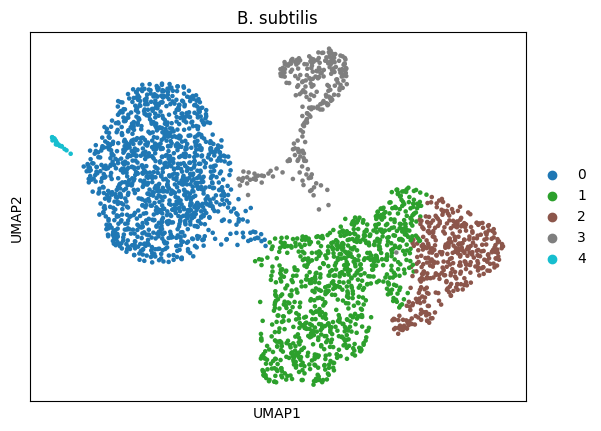

In [117]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="B. subtilis")
plt.show()

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [118]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
Both NB and ZINB not converged! Using NB without starting params
gene 100
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 200
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 300
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 400
Both NB and ZINB not converged! Using NB withou

In [119]:
data_gene.var

,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,...,Protein accession,Name,Symbol,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation
index,,,,,,,,,,,,,,,,,,,,,
Sr1,Gene Expression,PA01,30,0.012931,0.012848,98.922414,36.0,3.610918,30,0.017074,...,NaN,NaN,NaN,0.012931,0.017074,-0.004143,nb,0.012927,0.031389,0.0
aadK,Gene Expression,PA01,163,0.065733,0.063663,94.145115,183.0,5.214936,163,0.077217,...,NP_390556.1,aminoglycoside 6-adenylyltransferase,aadK,0.065733,0.077217,-0.011484,nb,0.065737,0.358580,0.0
aag,Gene Expression,PA01,15,0.006106,0.006088,99.461207,17.0,2.890372,15,0.007506,...,NP_391741.1,3-alkylated purines and hypoxanthine DNA glyco...,aag,0.006106,0.007506,-0.001399,nb,0.006101,0.022522,0.0
aapA,Gene Expression,PA01,273,0.108118,0.102663,90.193966,301.0,5.710427,273,0.117262,...,NP_390587.2,small amino acid permease,aapA,0.108118,0.117262,-0.009144,nb,0.108118,1.176949,0.0
abbA,Gene Expression,PA01,308,0.133980,0.125733,88.936782,373.0,5.924256,308,0.173501,...,NP_389295.1,regulator of AbrB repressor,abbA,0.133980,0.173501,-0.039521,nb,0.133983,0.451536,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
znuB,Gene Expression,PA01,106,0.042026,0.041167,96.192529,117.0,4.770685,106,0.048162,...,NP_388169.1,high affinity Zn(II) ABC transporter (permease),znuB,0.042026,0.048162,-0.006136,nb,0.042036,0.251568,0.0
znuC,Gene Expression,PA01,33,0.013649,0.013557,98.814655,38.0,3.663562,33,0.017773,...,NP_388168.1,Zn(II) transporter (ATP-binding protein),znuC,0.013649,0.017773,-0.004124,nb,0.013660,0.044729,0.0
zosA,Gene Expression,PA01,36,0.015805,0.015681,98.706897,44.0,3.806662,36,0.022020,...,NaN,NaN,NaN,0.015805,0.022020,-0.006216,nb,0.015804,0.034633,0.0


## Find optimal correlation matrix scaling and generate synthetic null data

In [120]:
importlib.reload(cd)
xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
print(xmin)

Factor: 1 - Error: 61.062145526926074
Factor: 2 - Error: 41.61230366138131
Factor: 3.6180339999999998 - Error: 47.5639997000499
Factor: 2 - Error: 41.61230366138131
Factor: 2.61803399102434 - Error: 42.6728986049149
Factor: 1.61803399 - Error: 41.928476205147085
Factor: 2.236067977595943 - Error: 41.5709760988543
Factor: 2.3819660117007944 - Error: 42.03119452115826
Factor: 2.1458980341048512 - Error: 41.553153060038696
Factor: 2.0901699441509773 - Error: 41.50337615883041
Factor: 2.055728090361706 - Error: 41.58788587302456
Factor: 2.11145618031558 - Error: 41.759568018114386
Factor: 2.077014326682086 - Error: 41.63394466492494
Factor: 2.0983005628466884 - Error: 41.846903049848464
Factor: 2.085144945437299 - Error: 41.685404726106
Factor: 2.0932755641330094 - Error: 41.53792009143197
Factor: 2.0882505654420584 - Error: 41.40961663161148
Factor: 2.087064324160264 - Error: 41.461600318279295
Factor: 2.088983702869183 - Error: 41.479646030872075
Factor: 2.0877974615927544 - Error: 41.53

In [121]:
importlib.reload(cd)

# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


In [127]:
importlib.reload(cd)
n, p = data_gene.X.shape
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, new_data_shape=(2*n, p),
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)


In [128]:
data_null_gen

AnnData object with n_obs × n_vars = 5568 × 2951

In [129]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [130]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

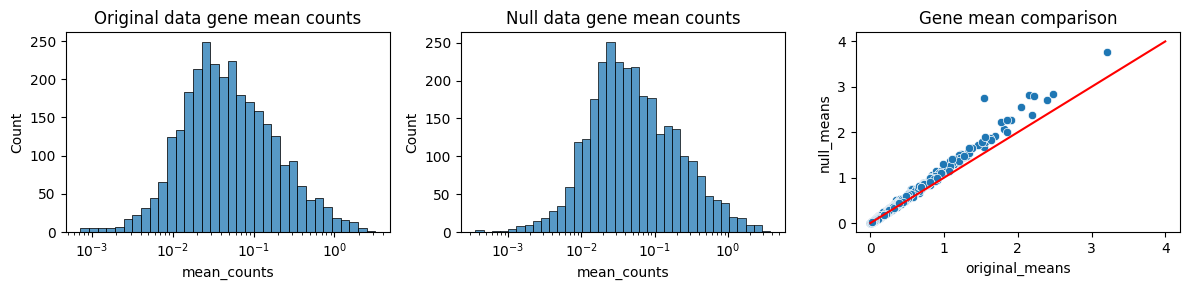

SignificanceResult(statistic=0.9974085258623435, pvalue=0.0)


In [131]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

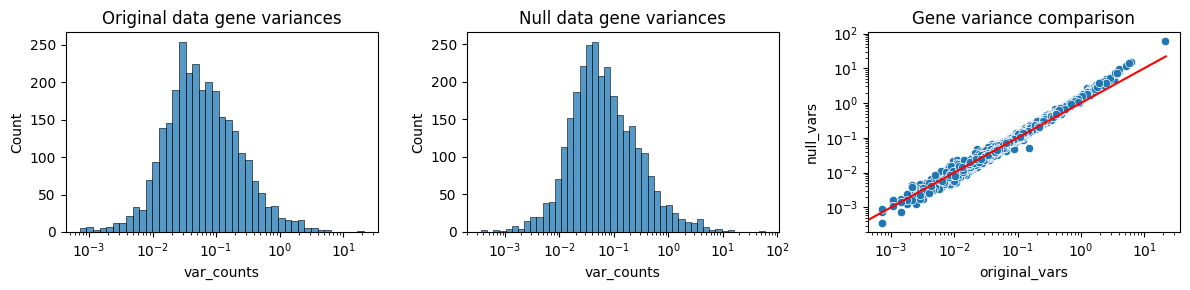

SignificanceResult(statistic=0.9945072531930294, pvalue=0.0)
[[1.         0.97488478]
 [0.97488478 1.        ]]


In [132]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

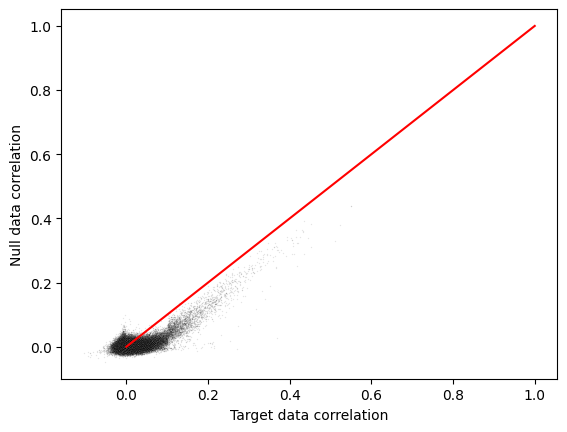

In [133]:
cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.xlabel("Target data correlation")
plt.ylabel("Null data correlation")

plt.show()

### Process null data

In [134]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [135]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform", seed=1234)
data_null_gen.layers["counts"] = data_null_gen.X.copy()

k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]
res_opt = data_gene.uns["BacSC_params"]["res_opt"]
print(n_neighbors_opt)

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


20


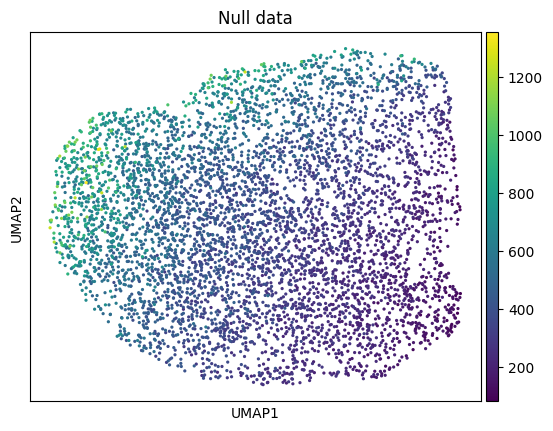

In [140]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [19]:
# data_null_gen.write(data_path + "/null_data_opt.h5ad")

In [25]:
# data_null_gen = sc.read_h5ad(data_path + "/null_data_opt.h5ad")
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

In [137]:
n_splits = 1
rng = np.random.default_rng(2345)
seeds = rng.choice(1000, n_splits)
null_pvals_dict = {}
min_pvals_null = []
c = 0
res_start = 0.01
res_step = 0.01

for s in seeds:
    res2 = res_start
    twoclust = False
    nclust = 1
    was_greater = False
    max_res_1_cluster = 0
    
    while twoclust is False:
        if nclust < 2:
            if res2 > max_res_1_cluster:
                max_res_1_cluster = res2
            elif max_res_1_cluster > 0: 
                res_step = res_step / 2
            if was_greater:
                res2 += res_step
            else:
                res2 += res_step * 5
        else:
            was_greater = True
            min_res_2plus_clusters = res2
            res2 -= res_step
        res2 = np.round(res2, 5)
        sc.tl.leiden(data_null_gen, resolution=res2, key_added=f"leiden_{c}", random_state=s)
        nclust = len(data_null_gen.obs[f"leiden_{c}"].unique())
        if nclust == 2:
            twoclust = True
        print(f"resolution: {res2}, clusters: {nclust}, step: {res_step}")
            
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] == "0"]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] != "0"]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    null_pvals_dict[c] = null_pvals

    clusters = data_gene.obs["leiden_opt"].unique()
            
    min_pvals_null.append(np.min(null_pvals))
            
    print(f"split {c+1}/{n_splits} - Resolution {res2}")

    res_start = res2 - 0.05
    c += 1
    
best_split = np.where(min_pvals_null == np.max(min_pvals_null))[0][0]
print(f"Best split: No. {best_split} - seed: {seeds[best_split]} - minimal p-value: {min_pvals_null[best_split]}")

resolution: 0.06, clusters: 1, step: 0.01
resolution: 0.11, clusters: 2, step: 0.01
split 1/1 - Resolution 0.11
Best split: No. 0 - seed: 111 - minimal p-value: 6.577817221177584e-277


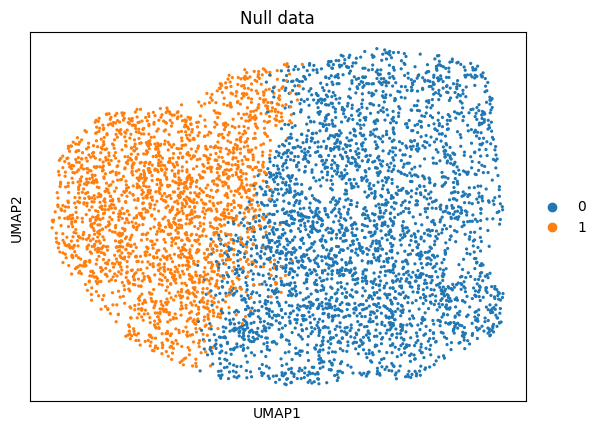

In [138]:
sc.pl.umap(data_null_gen, color=f"leiden_{best_split}", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [139]:
data_null_gen.obs["leiden_best"] = data_null_gen.obs[f"leiden_{best_split}"]

# data_null_gen.write(data_path + "/null_data_opt.h5ad")

In [82]:
X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] == "0"]
X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] != "0"]
null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue

In [155]:
importlib.reload(cd)
clusters = data_gene.obs["leiden_opt"].unique()
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05
rng = np.random.default_rng(4567)

for c in clusters:
    
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    
    n_cells_0 = X_data_0.shape[0]
    n_cells_1 = X_data_1.shape[0]
    
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] != "0"]
    X_null_gen_0 = X_null_gen_0[rng.integers(X_null_gen_0.shape[0], size=n_cells_0),:]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] == "0"]
    X_null_gen_1 = X_null_gen_1[rng.integers(X_null_gen_1.shape[0], size=n_cells_1),:]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    
    pvals_data = ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue
    p_data = pd.DataFrame({"pval_data": pvals_data}, index=data_gene_nonzero.var.index)
    pval_null_gen = pd.DataFrame({"pval_null": null_pvals}, index=data_null_gen.var.index)
    
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 0 - DE genes: 0; Minimum q value: 0.05728788977519942
Cluster 2 - DE genes: 0; Minimum q value: 0.2664359861591695
Cluster 3 - DE genes: 38; Minimum q value: 0.02631578947368421
Cluster 1 - DE genes: 0; Minimum q value: 0.163
Cluster 4 - DE genes: 41; Minimum q value: 0.02702702702702703


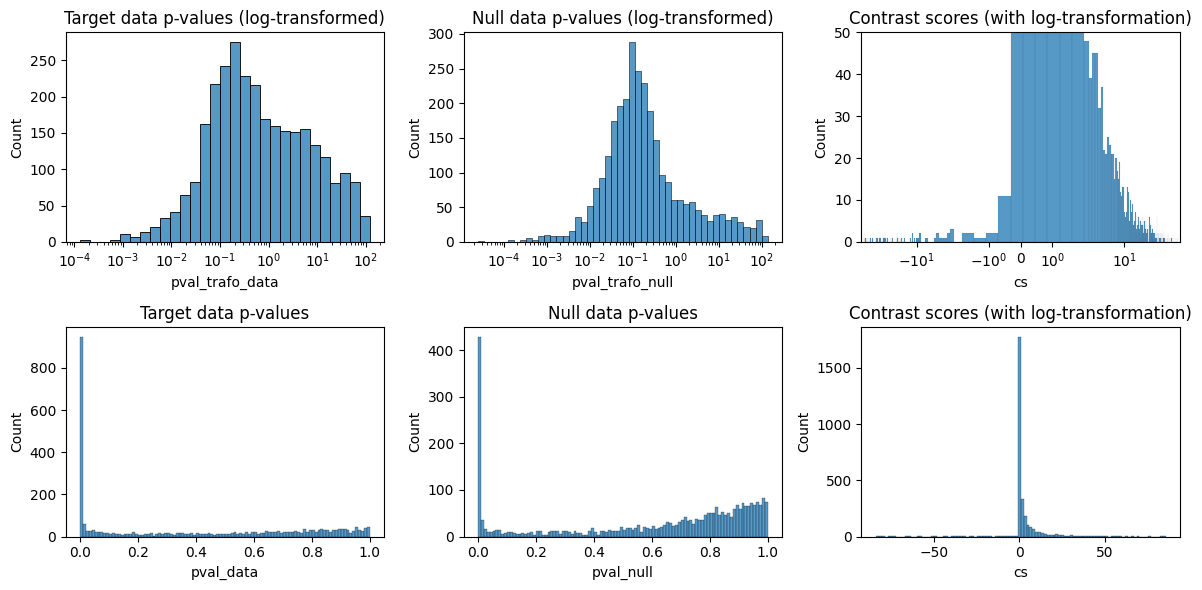

In [150]:
c = "0"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_trafo_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_trafo_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (with log-transformation)")


plt.tight_layout()
plt.show()

In [156]:
for c in clusters:
    print(f"cluster {c}")
    print(pvals_log_gen[c]["q"].value_counts().sort_index())
    print("")

cluster 0
0.057288    1379
0.057720       7
0.058357       2
0.058991      19
0.059113      14
            ... 
0.241000       2
0.241758       5
0.241874       3
0.242194       1
1.000000     581
Name: q, Length: 307, dtype: int64

cluster 2
0.266436     867
0.266974       2
0.267039      26
0.268374       3
0.269613       7
            ... 
0.544211       1
0.545502       1
0.545693       3
0.546457       1
1.000000    1046
Name: q, Length: 315, dtype: int64

cluster 3
0.026316      38
0.073171       3
0.090909       3
0.173913       2
0.212766       1
0.224490       2
0.260000       1
0.450980       1
0.730769       1
0.830189       1
0.842105       4
0.958225    1092
0.960904       2
0.960938       1
0.963112     339
0.963807       1
0.964501       1
0.964572       3
0.965264       1
1.000000    1454
Name: q, dtype: int64

cluster 1
0.163000    1000
0.163184       5
0.163205       6
0.163547       4
0.164706       5
            ... 
0.368470       2
0.368765       1
0.369059       

In [152]:
pvals_log_gen["4"].sort_values("cs", ascending=False)[:30]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
index,,,,,,
cotJC,6.838582e-13,0.874662,12.165034,0.058160,12.106874,0.035714
spoIVA,1.439850e-12,0.702102,11.841683,0.153600,11.688083,0.035714
spoVID,1.358092e-12,0.633071,11.867071,0.198547,11.668523,0.035714
prkA,2.587155e-12,0.720824,11.587178,0.142171,11.445007,0.035714
glgC,5.956568e-12,0.931586,11.225004,0.030777,11.194227,0.035714
gerQ,9.880297e-12,0.849429,11.005230,0.070873,10.934357,0.035714
safA,1.622643e-11,0.755260,10.789777,0.121904,10.667873,0.035714
spoIIID,1.198123e-10,0.782996,9.921499,0.106241,9.815258,0.035714
comER,2.347536e-10,0.909753,9.629388,0.041076,9.588311,0.035714


In [32]:
data_gene_nonzero.uns["ClusterDE_results"] = pvals_log_gen

data_gene_nonzero.uns["ClusterDE_results"]['params'] = {'groupby': 'leiden_opt',
  'reference': 'rest',
  'use_raw': False,
  'layer': None,
}

In [18]:
# data_gene_nonzero.write(data_path + "/filtered_data_maxpool_processed_cluster.h5ad")

In [9]:
data_gene_nonzero = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed_cluster.h5ad")


In [9]:
data_gene.var

,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,...,nb_umi,Intercept_step1_sct,log_umi_step1_sct,dispersion_step1_sct,mean,std,Locus tag,Protein accession,Name,Symbol
index,,,,,,,,,,,,,,,,,,,,,
Sr1,Gene Expression,PA01,30,0.012931,0.012848,98.922414,36.0,3.610918,30,0.017074,...,-0.029584,-4.586321,0.095632,0.101964,-4.293682,0.473112,NaN,NaN,NaN,NaN
aadK,Gene Expression,PA01,163,0.065733,0.063663,94.145115,183.0,5.214936,163,0.077217,...,1.805381,NaN,NaN,NaN,-2.245714,0.625123,BSU_26790,NP_390556.1,aminoglycoside 6-adenylyltransferase,aadK
aag,Gene Expression,PA01,15,0.006106,0.006088,99.461207,17.0,2.890372,15,0.007506,...,-0.052299,-7.060510,0.780658,0.069086,-4.994343,0.371819,BSU_38620,NP_391741.1,3-alkylated purines and hypoxanthine DNA glyco...,aag
aapA,Gene Expression,PA01,273,0.108118,0.102663,90.193966,301.0,5.710427,273,0.117262,...,2.313870,-6.187090,1.560799,0.020054,-1.395484,0.528697,BSU_27090,NP_390587.2,small amino acid permease,aapA
abbA,Gene Expression,PA01,308,0.133980,0.125733,88.936782,373.0,5.924256,308,0.173501,...,2.437001,NaN,NaN,NaN,-1.124802,0.462729,BSU_14120,NP_389295.1,regulator of AbrB repressor,abbA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
znuB,Gene Expression,PA01,106,0.042026,0.041167,96.192529,117.0,4.770685,106,0.048162,...,1.190302,NaN,NaN,NaN,-2.879180,0.605192,BSU_02870,NP_388169.1,high affinity Zn(II) ABC transporter (permease),znuB
znuC,Gene Expression,PA01,33,0.013649,0.013557,98.814655,38.0,3.663562,33,0.017773,...,-0.040122,-8.111126,1.504564,0.069545,-4.231052,0.458007,BSU_02860,NP_388168.1,Zn(II) transporter (ATP-binding protein),znuC
zosA,Gene Expression,PA01,36,0.015805,0.015681,98.706897,44.0,3.806662,36,0.022020,...,-0.036790,-1.751490,-0.975499,0.106674,-4.102461,0.514669,NaN,NaN,NaN,NaN


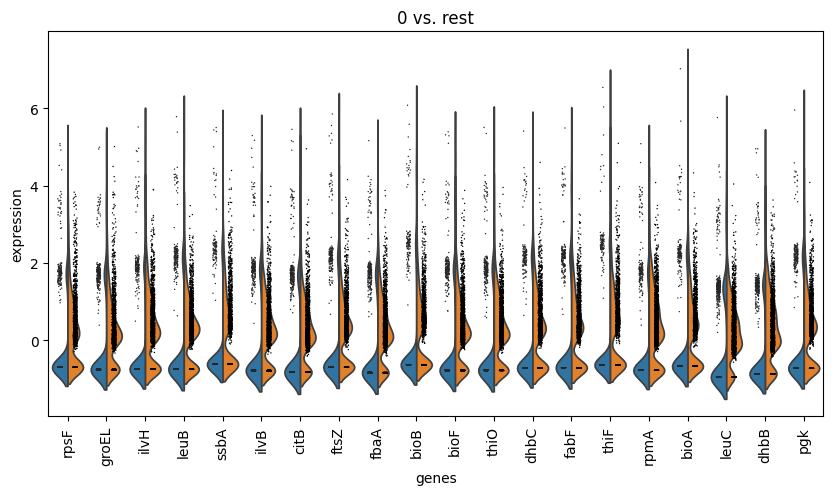

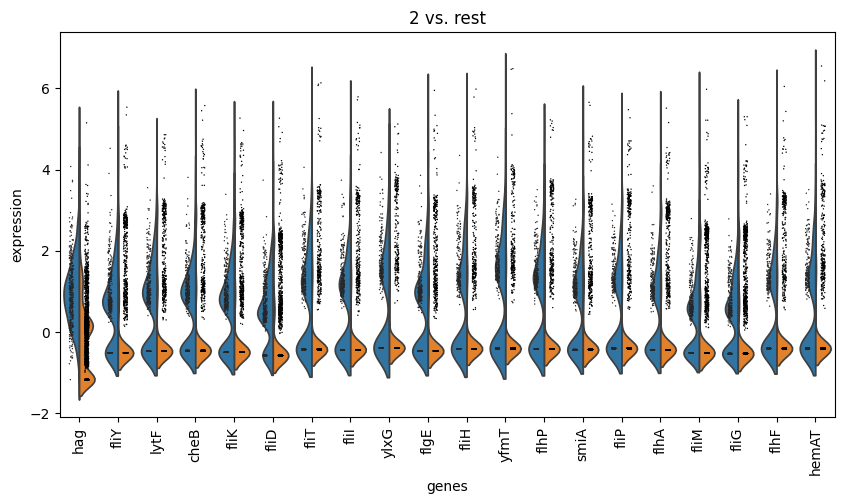

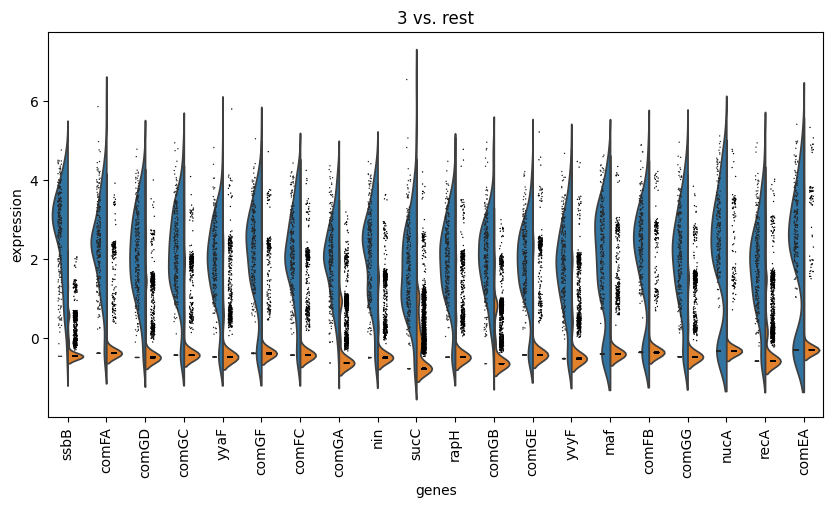

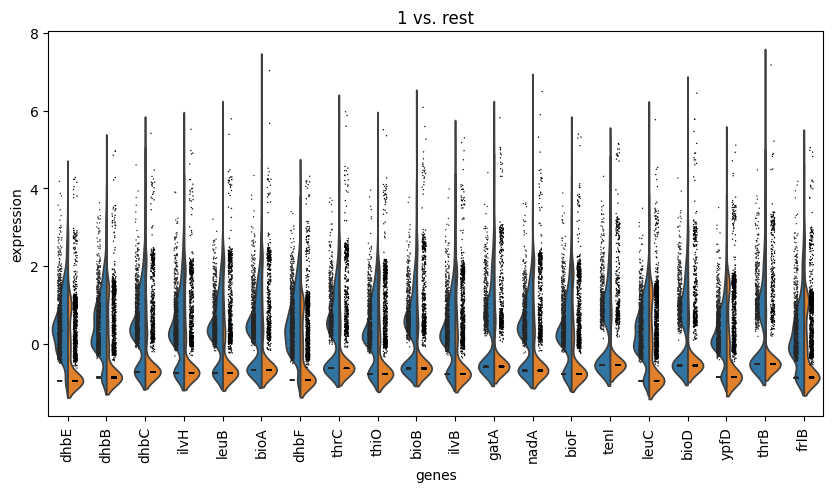

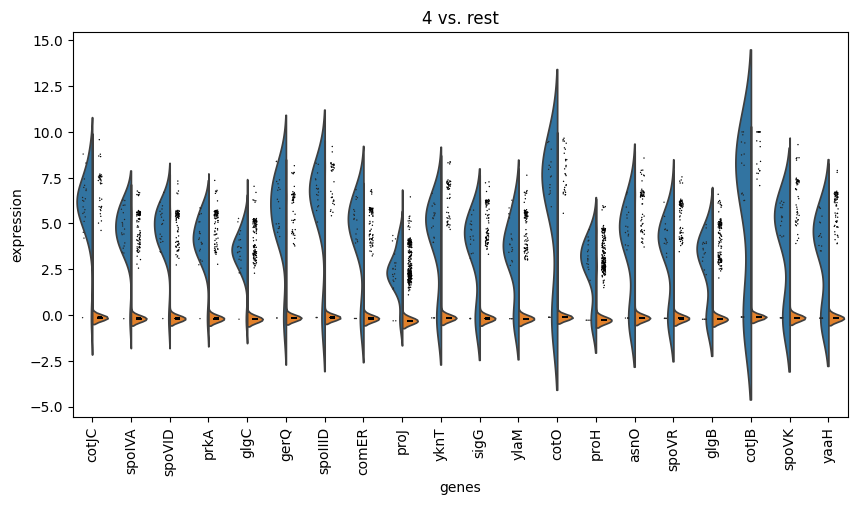

In [10]:
n_genes = 20
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    with plt.rc_context({"figure.figsize": (10, 5)}):
        sc.pl.rank_genes_groups_violin(data_gene_nonzero, gene_names=plot_genes, key="ClusterDE_results", groups=c)

In [11]:


all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    all_marker_genes += plot_genes
    print(f"Cluster {c}")
    print(data_gene.var.loc[plot_genes, ["Locus tag", "Name", "Symbol"]])

Cluster 0
       Locus tag                                               Name Symbol
index                                                                     
rpsF   BSU_40910                         ribosomal protein S6 (BS9)   rpsF
groEL  BSU_06030                           chaperonin large subunit  groEL
ilvH   BSU_28300         acetohydroxy-acid synthase (small subunit)   ilvH
leuB   BSU_28270                    3-isopropylmalate dehydrogenase   leuB
ssbA   BSU_40900                  single-strand DNA-binding protein   ssbA
ilvB   BSU_28310         acetohydroxy-acid synthase (large subunit)   ilvB
citB   BSU_18000       aconitate hydratase (bifunctional aconitase)   citB
ftsZ   BSU_15290                   cell-division initiation protein   ftsZ
fbaA   BSU_37120                 fructose-1,6-bisphosphate aldolase   fbaA
bioB   BSU_30200                                    biotin synthase   bioB
bioF         NaN                                                NaN    NaN
thiO   BSU_1167

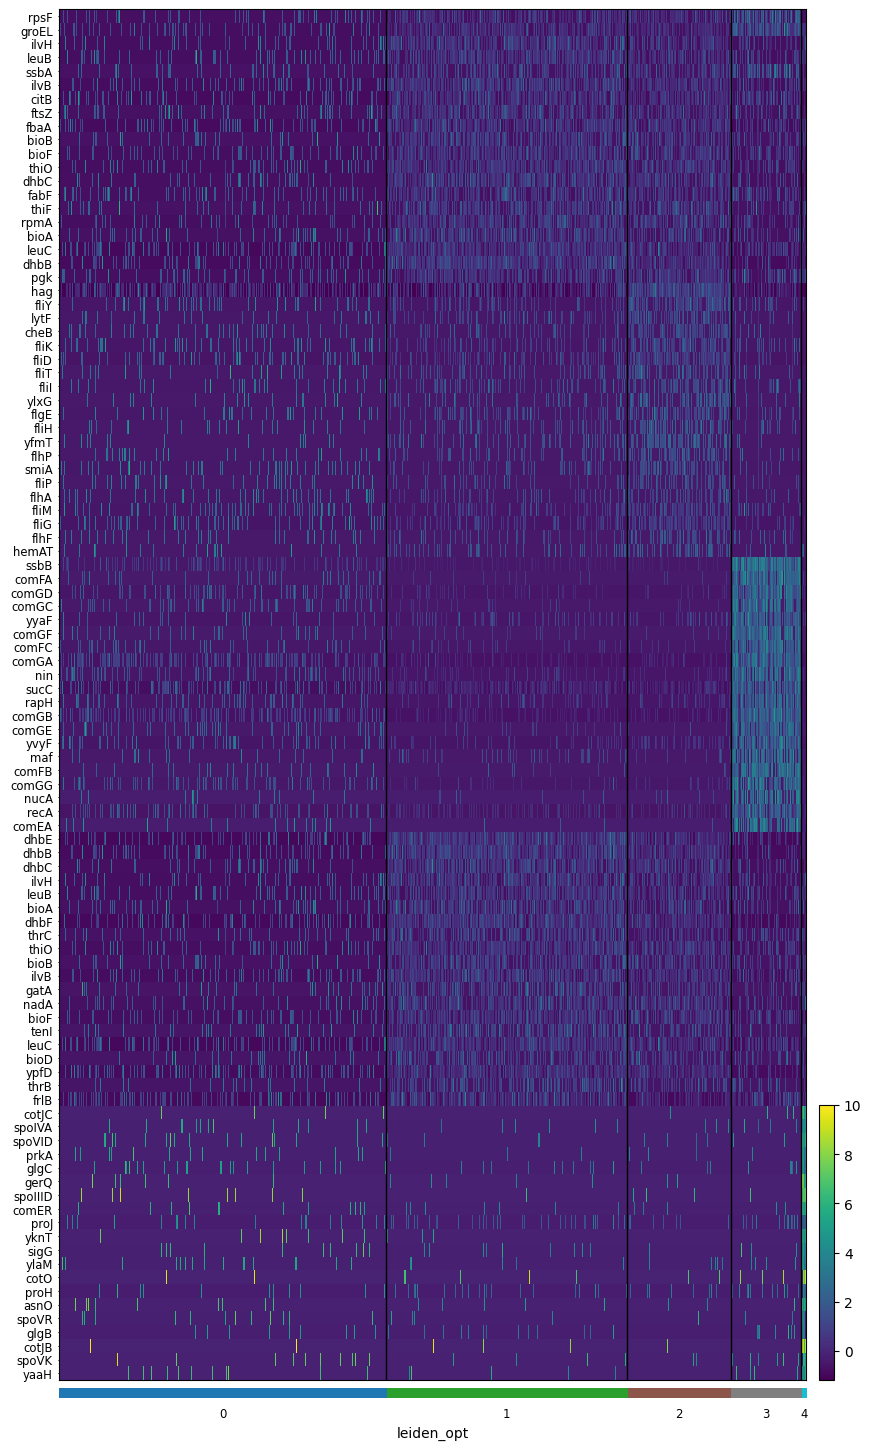

In [12]:

sc.pl.heatmap(data_gene_nonzero, all_marker_genes, groupby='leiden_opt', swap_axes=True, show_gene_labels=True)

In [72]:
data_gene_nonzero

AnnData object with n_obs × n_vars = 2784 × 2949
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt', 'is_c'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std', 'Locus tag', 'Protein accession', 'Name', 'Symbol', 'pval_cluster_0_gen', 'q_cluster_0_gen', 'DE_cluster_0_gen', 'pval_cluster_2_gen', 'q_cluster_2_gen', 'DE_cluster_2_gen', 'pval_cluster_3_gen', 'q_cluster_3_gen', 'DE_cluster_3_gen', 'pval_cluster_1_gen', 'q_cluster_1_gen', 'DE_cluster_1_gen', 'pval_cluster_4_gen', 'q_cluster_4_gen', 'DE_cluster_4_gen'
  

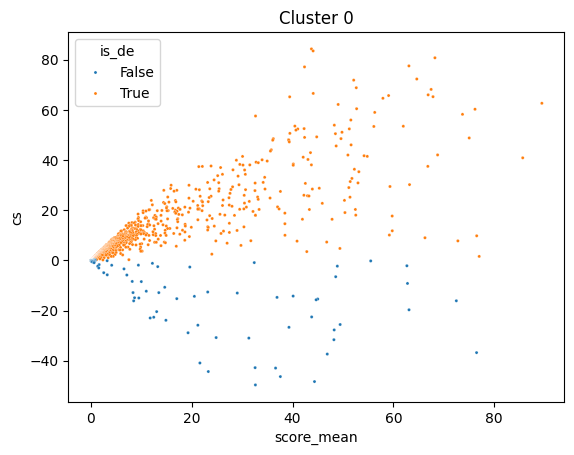

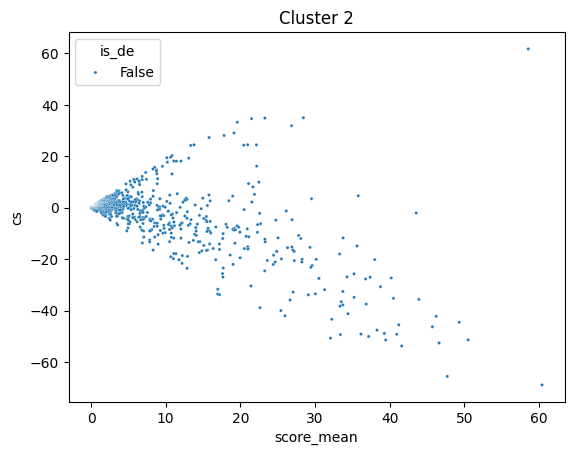

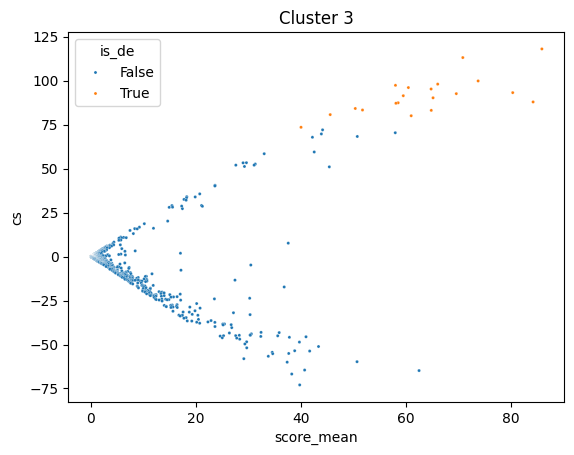

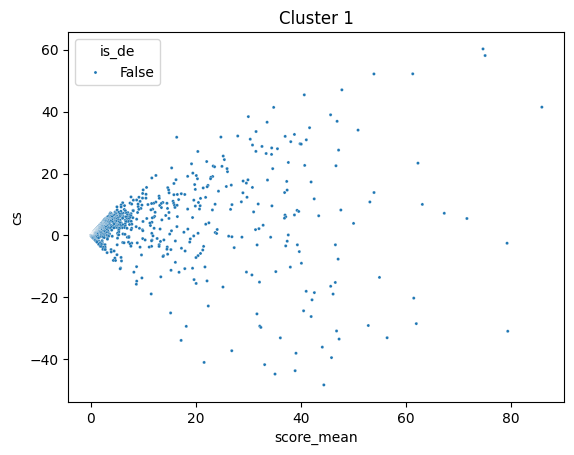

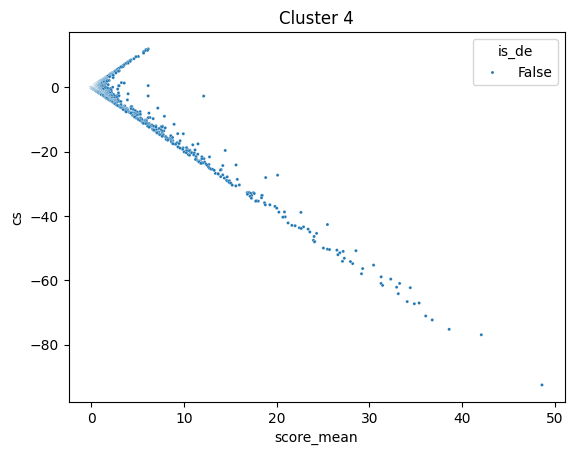

In [32]:
for c in clusters:
    pvals_test = data_gene_nonzero.uns["ClusterDE_results"][c]

    pvals_test["score_mean"] = (pvals_test["pval_trafo_data"] + pvals_test["pval_trafo_null"])/2
    pvals_test["is_de"] = (pvals_test["q"] <= 0.05)

    sns.scatterplot(pvals_test, x="score_mean", y="cs", hue="is_de", alpha=1, s=5)
    plt.title(f"Cluster {c}")
    plt.show()

In [94]:
sc.tl.rank_genes_groups(data_gene_nonzero, "leiden_opt", method="wilcoxon", layer="vst_counts")

In [95]:
data_gene_nonzero.uns["rank_genes_groups"]

{'params': {'groupby': 'leiden_opt',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': 'vst_counts',
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('secY', 'dhbF', 'hag', 'ssbB', 'cotJC'),
            ('adk', 'dhbE', 'fliY', 'comGB', 'spoVID'),
            ('sdpB', 'dhbB', 'fliD', 'comFA', 'spoIVA'), ...,
            ('dhbB', 'comGG', 'comGD', 'rpoA', 'tufA'),
            ('ilvH', 'comGA', 'comGA', 'srfAA', 'adk'),
            ('rpmA', 'comGB', 'comGB', 'secY', 'secY')],
           dtype=[('0', 'O'), ('1', 'O'), ('2', 'O'), ('3', 'O'), ('4', 'O')]),
 'scores': rec.array([( 15.005483 ,  22.00908 , 20.136986,  25.696064,  7.1826243),
            ( 11.9095125,  21.819273, 14.346412,  24.15212 ,  7.088259 ),
            (  6.3083754,  21.748487, 13.8374  ,  24.07904 ,  7.080163 ),
            ...,
            (-21.9783   ,  -9.263259, -5.391955, -11.152093, -3.9689116),
            (-22.218111 , -13.408663, -8.086466, -11.535383, -4.3116126),
    

In [96]:
data_gene_nonzero.var

,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,...,DE_cluster_2_gen,pval_cluster_3_gen,q_cluster_3_gen,DE_cluster_3_gen,pval_cluster_1_gen,q_cluster_1_gen,DE_cluster_1_gen,pval_cluster_4_gen,q_cluster_4_gen,DE_cluster_4_gen
index,,,,,,,,,,,,,,,,,,,,,
Sr1,Gene Expression,PA01,30,0.012931,0.012848,98.922414,36.0,3.610918,30,0.017074,...,False,0.925947,1.0,False,9.597405e-01,1.000000,False,0.762698,1.0,False
aadK,Gene Expression,PA01,163,0.065733,0.063663,94.145115,183.0,5.214936,163,0.077217,...,False,0.691711,1.0,False,6.686500e-01,1.000000,False,0.773896,1.0,False
aag,Gene Expression,PA01,15,0.006106,0.006088,99.461207,17.0,2.890372,15,0.007506,...,False,0.771089,1.0,False,8.975686e-01,0.309349,False,0.966596,1.0,False
aapA,Gene Expression,PA01,273,0.108118,0.102663,90.193966,301.0,5.710427,273,0.117262,...,False,0.493407,1.0,False,9.617810e-03,0.160571,False,0.703759,1.0,False
abbA,Gene Expression,PA01,308,0.133980,0.125733,88.936782,373.0,5.924256,308,0.173501,...,False,0.024878,1.0,False,6.193911e-04,0.160571,False,0.332239,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
znuB,Gene Expression,PA01,106,0.042026,0.041167,96.192529,117.0,4.770685,106,0.048162,...,False,0.814593,1.0,False,9.579716e-01,1.000000,False,0.389079,1.0,False
znuC,Gene Expression,PA01,33,0.013649,0.013557,98.814655,38.0,3.663562,33,0.017773,...,False,0.900456,1.0,False,9.241706e-01,0.318451,False,0.498743,1.0,False
zosA,Gene Expression,PA01,36,0.015805,0.015681,98.706897,44.0,3.806662,36,0.022020,...,False,0.858201,1.0,False,7.971689e-01,0.204263,False,0.919942,1.0,False


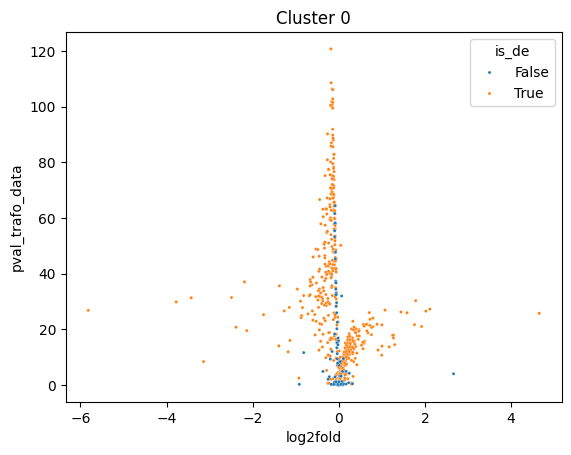

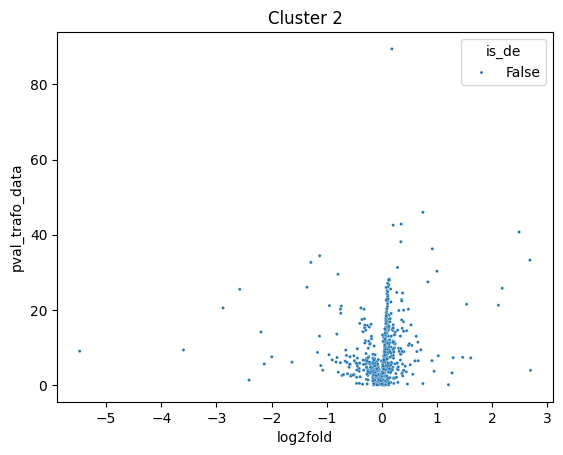

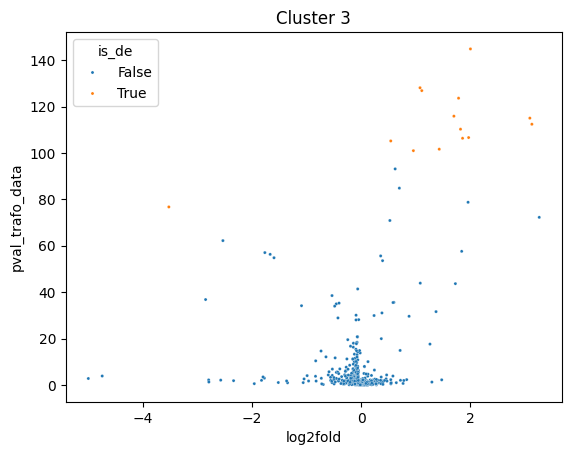

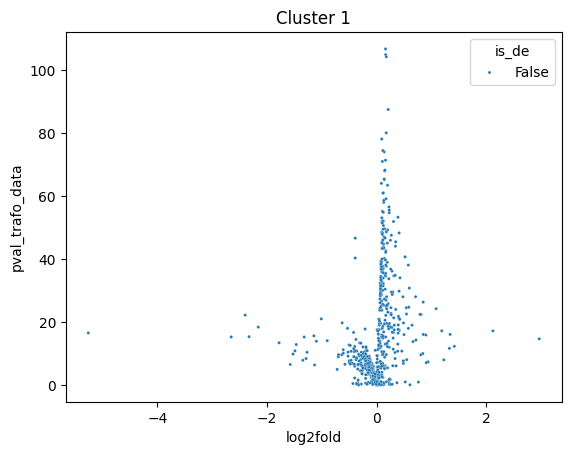

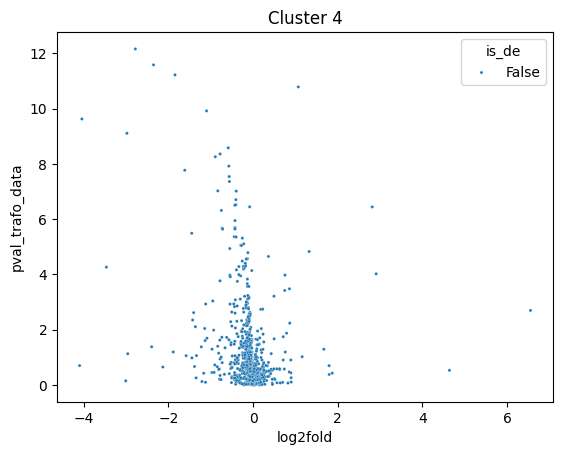

In [97]:
i=0
for c in clusters:
    pvals_test = data_gene_nonzero.uns["ClusterDE_results"][c]

    log2folds = pd.DataFrame({
        "log2fold": [x[c] for x in data_gene_nonzero.uns["rank_genes_groups"]["logfoldchanges"]],
        "pval": [x[c] for x in data_gene_nonzero.uns["rank_genes_groups"]["pvals"]],
    },index=[x[c] for x in data_gene_nonzero.uns["rank_genes_groups"]["names"]])
    pvals_test["log2fold"] = log2folds["log2fold"]
    pvals_test["pval_scanpy"] = log2folds["pval"]

    perc_zero_clust = (np.sum(data_gene_nonzero[data_gene_nonzero.obs["leiden_opt"] == c].layers["counts"].toarray() == 0, axis=0))/(data_gene_nonzero[data_gene_nonzero.obs["leiden_opt"] == c].shape[0])
    percent_zeros = pd.DataFrame({"perc_zero": perc_zero_clust}, index=data_gene_nonzero.var_names)
    pvals_test["percent_zero"] = percent_zeros["perc_zero"]

    sns.scatterplot(pvals_test[pvals_test["percent_zero"] < 25], x="log2fold", y="pval_trafo_data", hue="is_de", alpha=1, s=5)
    plt.title(f"Cluster {c}")
    plt.show()
    
    i += 1

<Axes: xlabel='pval_scanpy', ylabel='pval_data'>

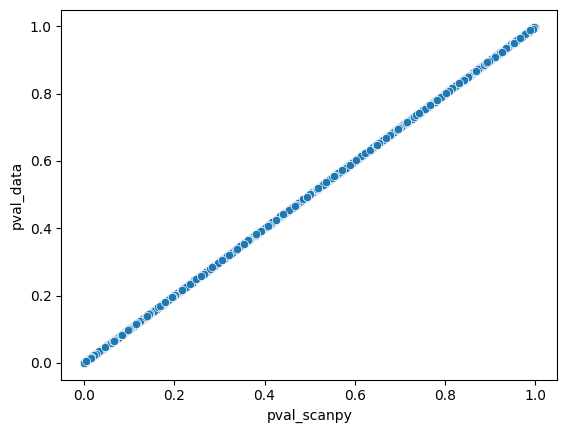

In [83]:
sns.scatterplot(pvals_test, x="pval_scanpy", y="pval_data")

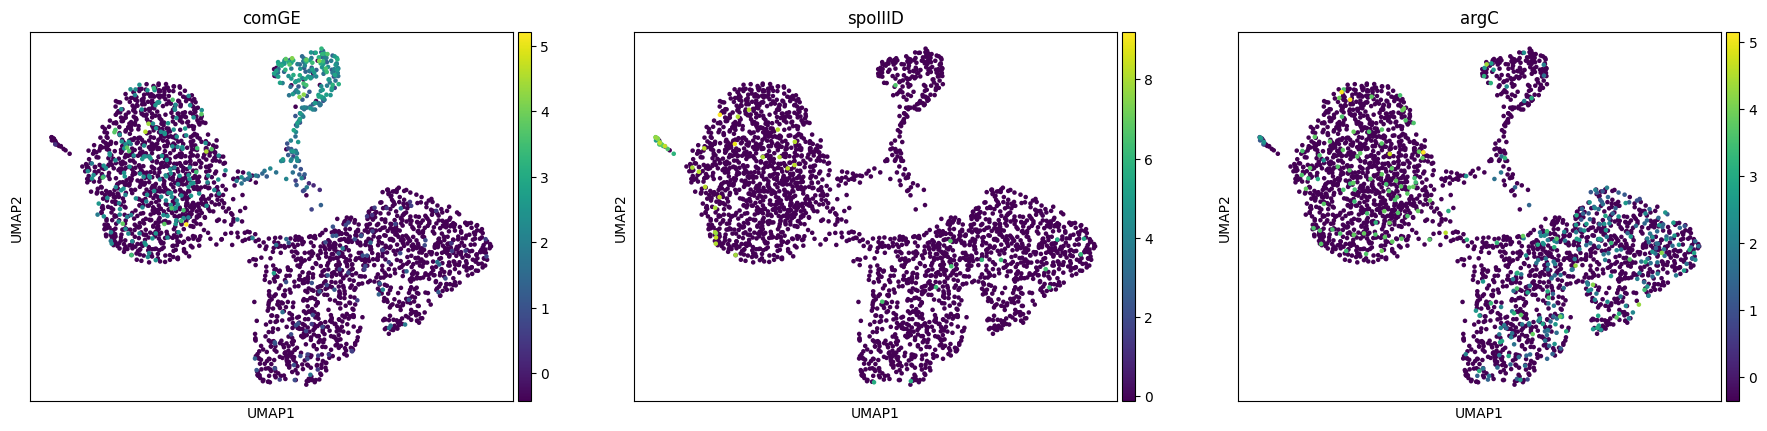

In [78]:
sc.pl.umap(data_gene, color=["comGE", "spoIIID", "argC"])